In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs=32 #using a batch size of 32

In [4]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/annotations')]

In [5]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images/pug_20.jpg'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images/Bombay_110.jpg'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images/Bombay_175.jpg'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images/Bengal_30.jpg'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/oxford-iiit-pet/images/Sphynx_144.jpg')]

ImageDataBunch is a custom DataLoader in the fastai library. I'm using the from_name_re method of the ImageDataBunch Class to extract the dependant variable - the name of the category of pet - from the name of the file which contains the image using the regular expression `pat`

The get_transforms method incorporates various data augmentation techniques - randomly flips the images horizontally, crops, warps them etc. Data augmentation helps the model generalize well, as all images in the training dataset may be of similar perspective, brightess or other parameters which may not be present in the validation and test datasets

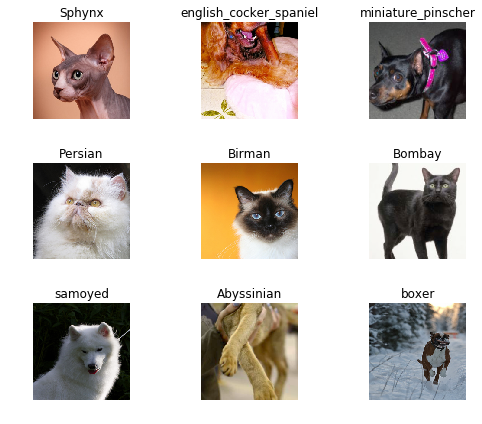

In [7]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

Here I use the `ResNet34` architecture with it's pre-trained weights, trained on 1 Million images of the ImageNet dataset. The `ResNet34` architecture consists of 34 layers of 2D Convolutional Layers, MaxPooling and Adaptive MaxPooling layers, and an Adam optimizer

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

I used the `lr_find` method of the fastai library to find an appropriate learning rate for training the model. When training the last 2 layers of the model, the rule of thumb used to pick a learning rate is to choose a point on the Loss v/s the Learning Rate plot where the negative slope is of the highest magnitude

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


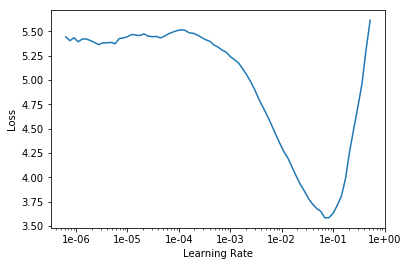

In [10]:
learn.lr_find()
learn.recorder.plot()

The `fit_one_cycle` method uses the [One-Cycle-Learning](https://arxiv.org/pdf/1803.09820.pdf) technique, which uses a different learning rate and momentum for different mini-batches. The shape of the curve of Learning Rate v/s the mini-batch trained is an inverted-U, while the shape of the momentum curve is U-shaped 

Here, only the last 2 layers of the model are trained, since the earlier layers are mode adept at recognizing basic features while the final layers are more specifically trained to identify the images the architecture was originally trained on

In [11]:
learn.fit_one_cycle(2, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.838800,0.310486,0.097429,00:45
1,0.454532,0.230858,0.071042,00:45


To see the performance of the model, I printed out the classes which the model got the most wrong using the `ClassificatoinInterpretation` class. Turns out that the categories with the most mistakes were most often the ones which are hard to tell apart even by humans. For example, digging in a bit I found an [article](https://mybritishshorthair.com/british-shorthair-vs-russian-blue/) on how to differenciate between a British Shorthair and a Russian Blue cat. All in all, I'd say the model is performing pretty decent already

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 8),
 ('Ragdoll', 'Birman', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Bengal', 'Maine_Coon', 4),
 ('english_setter', 'english_cocker_spaniel', 4),
 ('Maine_Coon', 'Ragdoll', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('boxer', 'american_bulldog', 2),
 ('havanese', 'scottish_terrier', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

In the next part, I 'unfreeze' the model, allowing all the layers to be trained, although since the initial layers are already expected to be good enough, they'll be trained at a lower learning rate than the outer layers

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


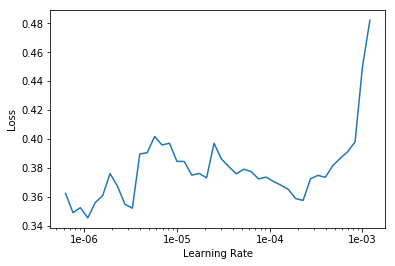

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Finally, using the `lr_finer` I choose the learning rate which doesn't cause the loss to diverge for the outer layer block, and the inner layer block to be trained at a learning rate 100 times less

In [14]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.330295,0.262330,0.083897,01:05
1,0.289184,0.252990,0.077131,01:05
2,0.214803,0.195732,0.058863,01:05
3,0.162393,0.193647,0.058187,01:05
